# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
)

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [2]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2022-01-01 00:00:00,caiso,22303.67
1,2022-01-01 01:00:00,caiso,21491.08
2,2022-01-01 02:00:00,caiso,21041.72
3,2022-01-01 03:00:00,caiso,20875.96
4,2022-01-01 04:00:00,caiso,20901.42


In [3]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

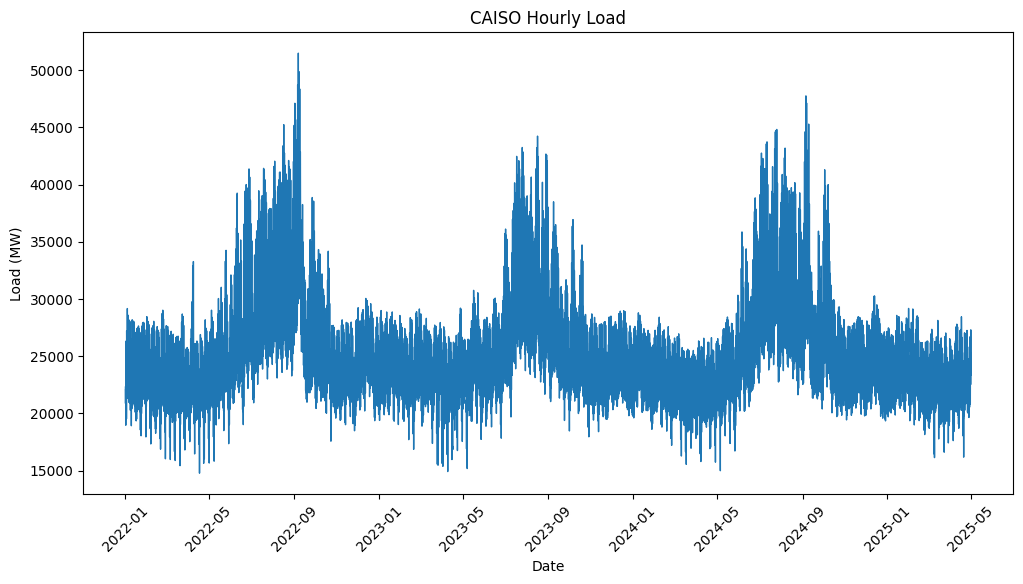

In [4]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=1)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [5]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-04"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index()

In [6]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
fm.add_generator(InteractionFeatureGenerator([["hour", "is_weekend"]]))
features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.dtypes)

(26952, 28)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dayofweek', 'month', 'day', 'quarter', 'year', 'dayofyear',
       'is_weekend', 'is_holiday', 'day_before_holiday', 'day_after_holiday',
       'hour_is_weekend'],
      dtype='object')
load                     float64
load_lag_24              float64
load_lag_48              float64
load_lag_168             float64
load_rolling_mean_24     float64
load_rolling_std_24      float64
load_rolling_min_24      float64
load_rolling_max_24      float64
load_rolling_mean_168    float64
load_rolling_std_168     float64
load_rolling_min_168     float64
load_rolling_max_168     float64
load_rolling_

In [7]:
from forecastiso.forecasters import LinearRegressionForecaster



forecaster = LinearRegressionForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                  "load_rolling_mean_24", "load_rolling_mean_168", "load_rolling_mean_720",
                  "hour", "month", "is_weekend", "day", "hour_is_weekend"],
    target_col="load"
)

forecaster.fit(features_df)

prediction = forecaster.predict(horizon=24)


In [8]:
prediction

0     22785.400761
1     22799.307832
2     23014.370196
3     23245.485559
4     23400.021468
5     23631.806362
6     24114.729749
7     24717.188124
8     25228.490125
9     25369.397533
10    25200.827288
11    24899.471547
12    24626.348900
13    24488.217702
14    24479.190273
15    24564.431117
16    24855.774498
17    25431.009321
18    25880.821021
19    25982.714063
20    25731.358746
21    25230.168424
22    24422.937013
23    23626.753624
dtype: float64

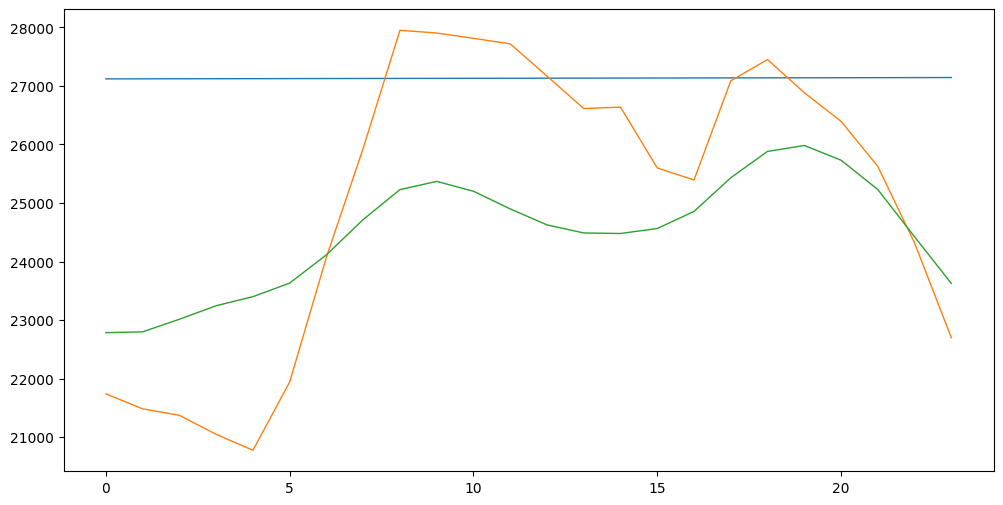

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(ground_truth, label="Ground Truth", linewidth=1)
plt.plot(prediction, label="Prediction", linewidth=1)
plt.show()